In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from tqdm import tqdm

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn import set_config

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectPercentile, chi2

from sklearn.metrics import r2_score, mean_squared_error,accuracy_score, make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV







In [2]:
df = pd.read_parquet("../data/diamonds.parquet")

In [3]:
df

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,N,...,1.79,M,M,unknown,unknown,unknown,unknown,unknown,unknown,200
1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,N,...,1.78,STK,STK,unknown,unknown,unknown,unknown,unknown,unknown,200
2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,...,1.77,TN,M,unknown,unknown,unknown,unknown,unknown,unknown,200
3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,...,1.78,M,STK,unknown,unknown,unknown,unknown,unknown,unknown,200
4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,N,...,1.82,STK,STK,unknown,unknown,unknown,unknown,unknown,unknown,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,N,...,8.66,M,STK,unknown,unknown,unknown,unknown,unknown,unknown,1210692
219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,unknown,...,5.71,TK,XTK,unknown,unknown,Green,unknown,unknown,Fancy Light,1292500
219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,N,...,10.20,TN,M,unknown,unknown,unknown,unknown,unknown,unknown,1315496
219702,Princess,unknown,SI2,0.90,unknown,GIA,Good,Good,unknown,N,...,3.47,XTN,VTK,unknown,Faint,Red,unknown,unknown,Fancy,1350000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219704 entries, 0 to 219703
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   cut                          219704 non-null  object 
 1   color                        219704 non-null  object 
 2   clarity                      219704 non-null  object 
 3   carat_weight                 219704 non-null  float64
 4   cut_quality                  219704 non-null  object 
 5   lab                          219704 non-null  object 
 6   symmetry                     219704 non-null  object 
 7   polish                       219704 non-null  object 
 8   eye_clean                    219704 non-null  object 
 9   culet_size                   219704 non-null  object 
 10  culet_condition              219704 non-null  object 
 11  depth_percent                219704 non-null  float64
 12  table_percent                219704 non-null  float64
 13  meas

## Define the categories for transformations

We have numerical columns as well as categorical columns both of ordinal and nominal subtypes

#### Numerical 

In [5]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
#numerical_columns

#### Ordinals

In [6]:
ordinal_columns = ['clarity', 'culet_size', 'cut_quality', 'polish', 'symmetry']

In [7]:
clarity_ord = ['F', 'IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1',  'SI2', 'SI3', 'I1', 'I2','I3']
culet_size_ord = ['N', 'VS', 'S', 'M', 'SL', 'L', 'VL', 'EL', 'unknown']
cut_quality_ord = ['Ideal', 'Excellent',  'Very Good', 'Good', 'Fair', 'None', 'unknown']
polish_ord = ['Excellent','Very Good', 'Good', 'Fair', 'Poor']
symmetry_ord = ['Excellent','Very Good', 'Good', 'Fair', 'Poor']

#### Nominals

In [8]:
nominal_columns = ['cut', 'color','lab','eye_clean','culet_condition',\
                   'girdle_max', 'girdle_min',\
                   'fancy_color_intensity','fancy_color_dominant_color',\
                   'fancy_color_secondary_color','fancy_color_overtone',\
                   'fluor_color', 'fluor_intensity']
            
# for col in nominal_columns:
#     print(f" '{col}' has the following values: \n \t {df[col].unique()} \n")

#### From the course we know regression models don't do well with long tails. From the EDA notebook we know this has a very loooooong tail.

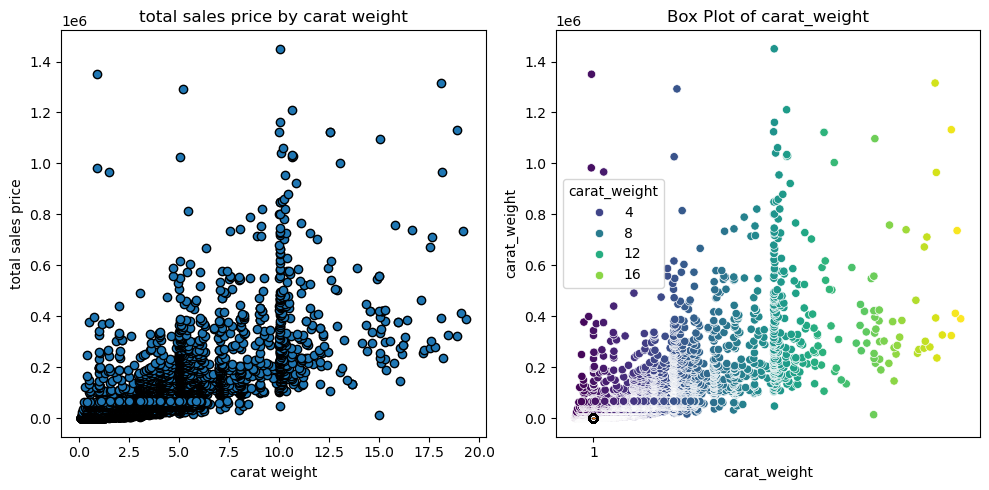

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram (price by carat weight)

ax1.scatter(x=df['carat_weight'], y=df['total_sales_price'],  edgecolor='black')
ax1.set_xlabel('carat weight')
ax1.set_ylabel('total sales price')
ax1.set_title('total sales price by carat weight')

# Box Plot (Whiskers)
ax2.boxplot(df['carat_weight'])
ax2.set_ylabel('carat_weight')
ax2.set_title('Box Plot of carat_weight')

# Create the plot
sns.scatterplot(x='carat_weight', y='total_sales_price', data=df, hue='carat_weight', palette='viridis')

plt.tight_layout()
plt.show()

#### We can try splitting this with everything in the box and whiskers as one model and eveything above that as another. <br> 
AND/OR <br> 
#### We can try taking the log of the prices to regularize it. Let's try in that order. 

In [10]:
df['carat_weight'].describe()

count    219704.000000
mean          0.755176
std           0.845892
min           0.080000
25%           0.310000
50%           0.500000
75%           1.000000
max          19.350000
Name: carat_weight, dtype: float64

In [11]:
df['total_sales_price'].describe()

count    2.197040e+05
mean     6.908035e+03
std      2.595944e+04
min      2.000000e+02
25%      9.580000e+02
50%      1.970000e+03
75%      5.207000e+03
max      1.449881e+06
Name: total_sales_price, dtype: float64

In [12]:
Q1_price, Q3_price = df['total_sales_price'].quantile(.25), df['total_sales_price'].quantile(.75)
IQR_price = Q3_price - Q1_price
IQR_price

np.float64(4249.0)

In [13]:
upper_lim_price = Q3_price + 1.5*IQR_price
upper_lim_price

np.float64(11580.5)

In [14]:
Q1_carat_weight, Q3_carat_weight = df['carat_weight'].quantile(.25), df['carat_weight'].quantile(.75)
IQR_carat_weight = Q3_carat_weight - Q1_carat_weight
IQR_carat_weight

np.float64(0.69)

In [15]:
upper_lim_carat_weight = Q3_carat_weight + 1.5*IQR_carat_weight
upper_lim_carat_weight

np.float64(2.035)

#### So the cutoff points are $11,580 and 2.04 carats. We can now see if splitting into two models will work. Let's try price.

In [16]:
filtered_df_low_price = df[df['total_sales_price'] < 11580]

In [17]:
filtered_df_high_price = df[df['total_sales_price'] > 11580]

In [18]:
filtered_df_low_cw = df[df['carat_weight'] < 2.04]

In [19]:
filtered_df_high_cw = df[df['carat_weight'] > 2.04]

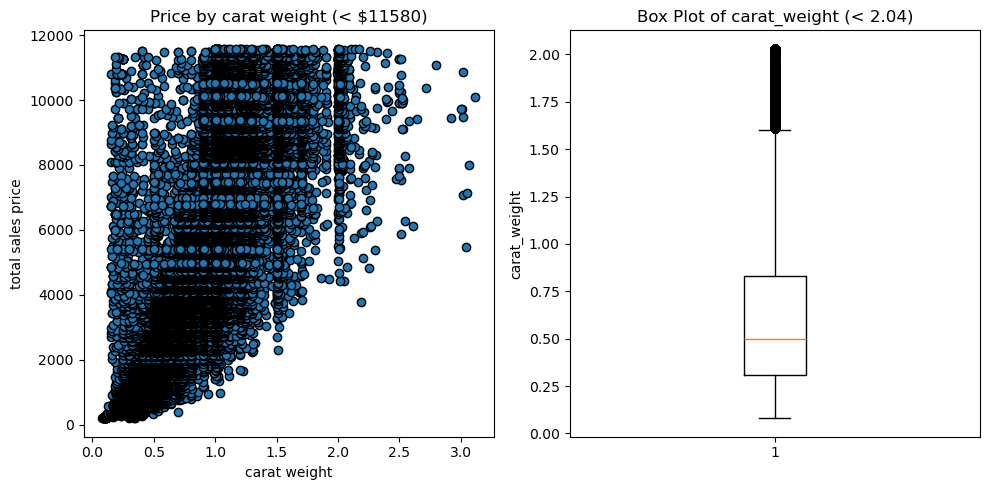

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram
ax1.scatter(x=filtered_df_low_price['carat_weight'], y=filtered_df_low_price['total_sales_price'],  edgecolor='black')
ax1.set_xlabel('carat weight')
ax1.set_ylabel('total sales price')
ax1.set_title('Price by carat weight (< $11580)')

# Box Plot (Whiskers)
ax2.boxplot(filtered_df_low_cw['carat_weight'])
ax2.set_ylabel('carat_weight')
ax2.set_title('Box Plot of carat_weight (< 2.04)')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()

OK, that's ... not as helpful as I was hoping. Perhaps the stones above the cutoff will look better.

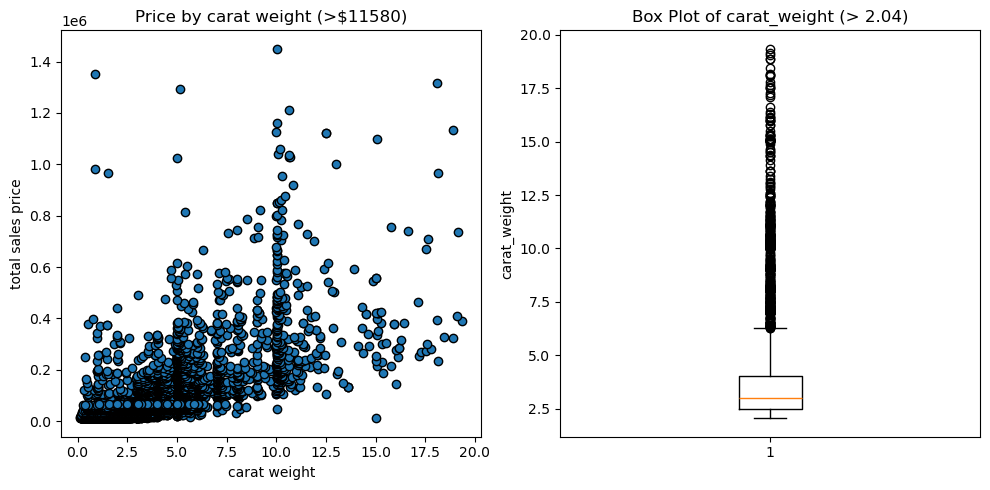

In [21]:
# Create the Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram
ax1.scatter(x=filtered_df_high_price['carat_weight'], y=filtered_df_high_price['total_sales_price'],  edgecolor='black')
ax1.set_xlabel('carat weight')
ax1.set_ylabel('total sales price')
ax1.set_title('Price by carat weight (>$11580)')

# Box Plot (Whiskers)
ax2.boxplot(filtered_df_high_cw['carat_weight'])
ax2.set_ylabel('carat_weight')
ax2.set_title('Box Plot of carat_weight (> 2.04)')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()

#### OK, that's not any better and together they show we're not going to be able to make this work by just splitting it into two models using either price or carat weight. We're going to need to try something else so let's go with the log of prices and/or carat weight.

#### But that chart from cell 20 is suspicious. Is there really a .15 carat diamond that's above the cutoff point which was 1.5 times the IQR?

In [22]:
ripoff = df[(df['total_sales_price'] > 11580) & (df['carat_weight'] < .2)]
ripoff

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
192450,Cushion Modified,unknown,I1,0.19,unknown,GIA,Good,Very Good,unknown,unknown,...,2.04,M,XTK,Blue,Medium,Pink,unknown,unknown,Fancy Intense,11970
192451,Cushion Modified,unknown,VS2,0.19,unknown,GIA,Good,Very Good,unknown,unknown,...,2.20,XTK,XTK,Blue,Strong,Pink,unknown,unknown,Fancy Intense,11970
192894,Oval,unknown,SI1,0.15,unknown,GIA,Very Good,Very Good,unknown,unknown,...,1.86,unknown,unknown,Blue,Medium,Pink,unknown,unknown,Fancy Intense,12150
199359,Cushion Modified,unknown,SI1,0.19,unknown,GIA,Very Good,Excellent,unknown,N,...,1.94,XTN,XTK,unknown,Faint,Pink,unknown,unknown,Fancy Intense,13680
200018,Radiant,unknown,VVS2,0.18,unknown,GIA,Good,Very Good,unknown,unknown,...,1.91,STK,XTK,unknown,Faint,Pink,unknown,unknown,Fancy Deep,16200
200035,Emerald,unknown,VS1,0.15,unknown,GIA,Good,Good,unknown,N,...,1.58,M,VTK,unknown,Faint,Pink,unknown,unknown,Fancy Intense,16200
210930,Marquise,unknown,SI2,0.16,unknown,GIA,Good,Very Good,unknown,unknown,...,1.64,VTK,XTK,unknown,Faint,Gray,unknown,unknown,Fancy,24320


#### NO KIDDING?!? <br> 
Man, they must have seen those poor folks comming. Wow.
<br> Well, anyway. Maybe regularizing the prices will work better

In [23]:
df['log_cw'] = np.log(df['carat_weight'])

In [24]:
df['log_price'] = np.log(df['total_sales_price'])

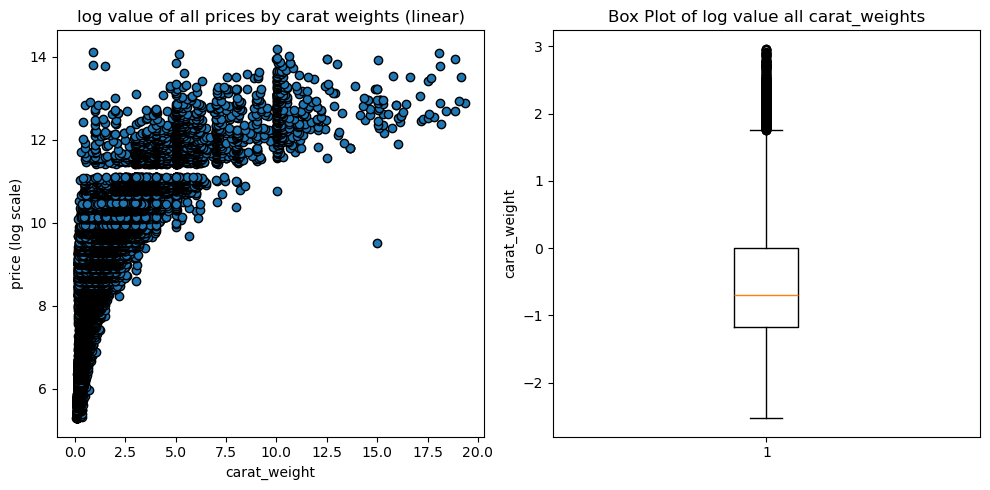

In [25]:
# Create the Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram
ax1.scatter(x=df['carat_weight'], y=df['log_price'],  edgecolor='black')
ax1.set_xlabel('carat_weight')
ax1.set_ylabel('price (log scale)')
ax1.set_title('log value of all prices by carat weights (linear)')

# Box Plot (Whiskers)
ax2.boxplot(df['log_cw'])
ax2.set_ylabel('carat_weight')
ax2.set_title('Box Plot of log value all carat_weights')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()

#### This is considerably better but there still are a lot of outliers. Lets's see what carat weight by price with both using log scale look like. No matter what, it still means we need to deal with the carat_weight outliers.

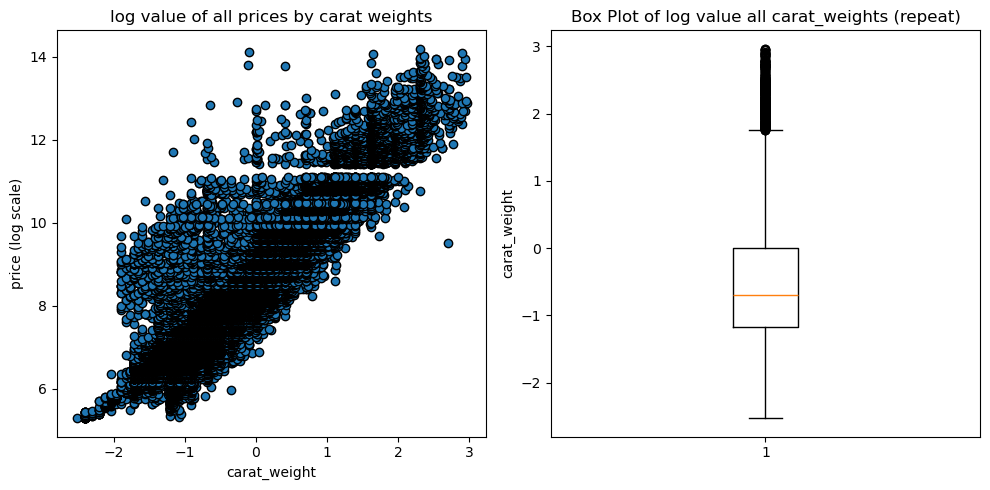

In [26]:
# Create the Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram
ax1.scatter(x=df['log_cw'], y=df['log_price'],  edgecolor='black')
ax1.set_xlabel('carat_weight')
ax1.set_ylabel('price (log scale)')
ax1.set_title('log value of all prices by carat weights')

# Box Plot (Whiskers)
ax2.boxplot(df['log_cw'])
ax2.set_ylabel('carat_weight')
ax2.set_title('Box Plot of log value all carat_weights (repeat)')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()

#### Ok, so regularization is needed here for sure. And I might as well do it for all the numeric columns.

#### I have two thoughts for this too. One is to use the outlier cutoff, the other is to YOLO it. >90% of the diamonds are < 2.5 carats. But, it's not really data science if you're not sciencing it. So, both it is. But I'm going to go with the cutoff at 2.5 carats. As for why carat weight when price will be used for prediction, I see less variation in it. 

In [27]:
solution_90 = df[df['carat_weight'] < 2.5]
solution_90

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price,log_cw,log_price
0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,N,...,M,unknown,unknown,unknown,unknown,unknown,unknown,200,-2.407946,5.298317
1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,N,...,STK,unknown,unknown,unknown,unknown,unknown,unknown,200,-2.407946,5.298317
2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,...,M,unknown,unknown,unknown,unknown,unknown,unknown,200,-2.407946,5.298317
3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,...,STK,unknown,unknown,unknown,unknown,unknown,unknown,200,-2.407946,5.298317
4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,N,...,STK,unknown,unknown,unknown,unknown,unknown,unknown,200,-2.407946,5.298317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219525,Radiant,unknown,VS1,0.76,unknown,GIA,Good,Very Good,unknown,N,...,XTK,unknown,unknown,Blue,unknown,unknown,Fancy Intense,399000,-0.274437,12.896717
219560,Oval,unknown,VS1,2.01,unknown,GIA,Good,Very Good,unknown,N,...,XTK,unknown,unknown,Pink,unknown,unknown,Fancy,439688,0.698135,12.993821
219684,Pear,unknown,VS2,1.51,unknown,GIA,Very Good,Very Good,unknown,N,...,unknown,unknown,Faint,Purple,Pink,unknown,Fancy Intense,966401,0.412110,13.781334
219685,Radiant,unknown,I1,0.89,unknown,GIA,Good,Good,unknown,N,...,VTK,Blue,Medium,Red,unknown,unknown,Fancy,982560,-0.116534,13.797917


In [28]:
solution_90.columns

Index(['cut', 'color', 'clarity', 'carat_weight', 'cut_quality', 'lab',
       'symmetry', 'polish', 'eye_clean', 'culet_size', 'culet_condition',
       'depth_percent', 'table_percent', 'meas_length', 'meas_width',
       'meas_depth', 'girdle_min', 'girdle_max', 'fluor_color',
       'fluor_intensity', 'fancy_color_dominant_color',
       'fancy_color_secondary_color', 'fancy_color_overtone',
       'fancy_color_intensity', 'total_sales_price', 'log_cw', 'log_price'],
      dtype='object')

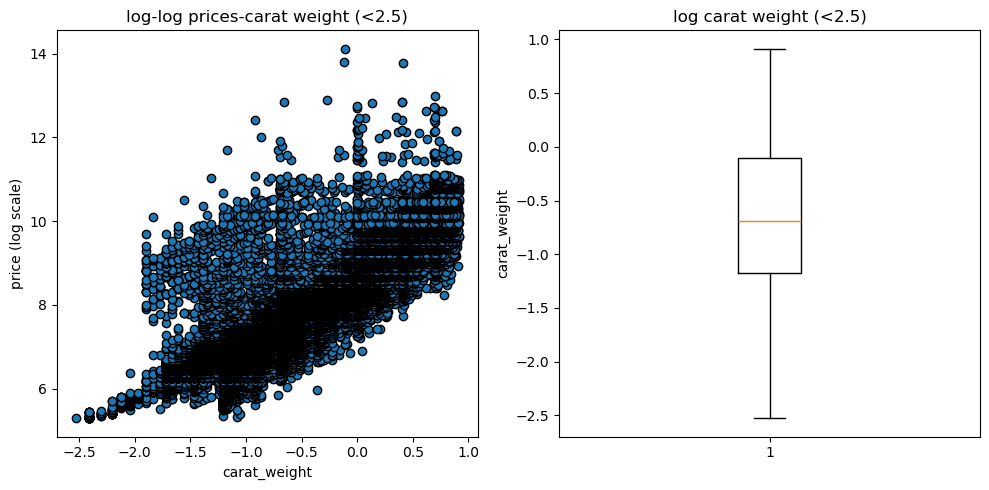

In [29]:
# Create the Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# Histogram
ax1.scatter(x=solution_90['log_cw'], y=solution_90['log_price'],  edgecolor='black')
ax1.set_xlabel('carat_weight')
ax1.set_ylabel('price (log scale)')
ax1.set_title('log-log prices-carat weight (<2.5)')

# Box Plot (Whiskers)
ax2.boxplot(solution_90['log_cw'])
ax2.set_ylabel('carat_weight')
ax2.set_title('log carat weight (<2.5)')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()



Yeah, I can work with that. I need to think about the price outliers part. The goal is to predict prices accurately. Getting rid of some outliers makes sense because they would be way overpriced. Before I commit to that, I need to see what > 2.5 stones looks like and what the difference going with the cutoff point does.

In [30]:
super_90 = df[df['carat_weight'] > 2.5]
super_90

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price,log_cw,log_price
165563,Oval,unknown,I2,3.04,unknown,GIA,Very Good,Very Good,unknown,N,...,unknown,Blue,Medium,Brown,Yellow,unknown,Fancy Light,5472,1.111858,8.607399
168479,Cushion Modified,unknown,SI1,2.61,unknown,GIA,Excellent,Excellent,unknown,unknown,...,XTK,unknown,Faint,Brown,unknown,unknown,Fancy,6108,0.959350,8.717355
169773,Cushion Modified,unknown,I2,2.51,unknown,GIA,Fair,Very Good,unknown,N,...,unknown,unknown,unknown,Brown,unknown,unknown,Fancy Dark,5874,0.920283,8.678291
173011,Round,G,I3,2.55,Very Good,GIA,Very Good,Very Good,Yes,N,...,STK,unknown,unknown,unknown,unknown,unknown,unknown,6268,0.936093,8.743213
174449,Cushion Modified,unknown,I2,3.02,unknown,GIA,Good,Very Good,unknown,unknown,...,unknown,Green,Medium,Yellow,Green,unknown,Fancy,7067,1.105257,8.863191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,Oval,unknown,VS1,10.04,unknown,GIA,Excellent,Excellent,unknown,unknown,...,unknown,unknown,unknown,Yellow,unknown,unknown,Fancy Vivid,1161102,2.306577,13.964880
219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,N,...,STK,unknown,unknown,unknown,unknown,unknown,unknown,1210692,2.365560,14.006703
219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,unknown,...,XTK,unknown,unknown,Green,unknown,unknown,Fancy Light,1292500,1.642873,14.072089
219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,N,...,M,unknown,unknown,unknown,unknown,unknown,unknown,1315496,2.894253,14.089724


In [31]:
super_90['carat_weight'].min()

np.float64(2.51)

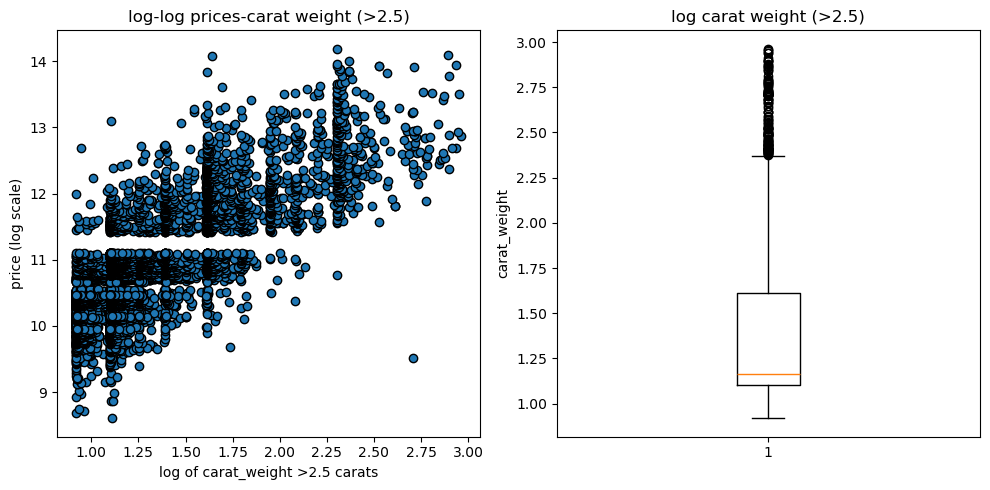

In [32]:
# Create the Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# Histogram
ax1.scatter(x=super_90['log_cw'], y=super_90['log_price'],  edgecolor='black')
ax1.set_xlabel('log of carat_weight >2.5 carats')
ax1.set_ylabel('price (log scale)')
ax1.set_title('log-log prices-carat weight (>2.5)')

# Box Plot (Whiskers)
ax2.boxplot(super_90['log_cw'])
ax2.set_ylabel('carat_weight')
ax2.set_title('log carat weight (>2.5)')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()

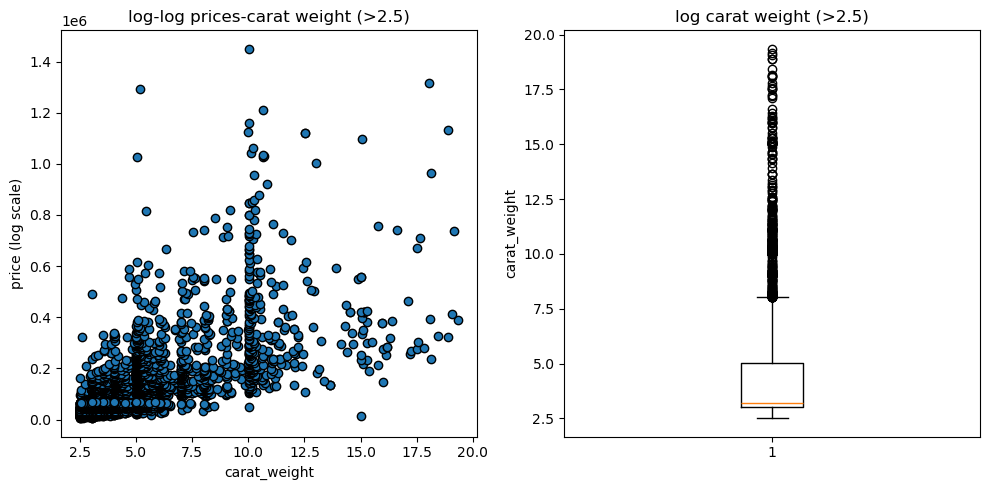

In [33]:
# Create the Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# Histogram
ax1.scatter(x=super_90['carat_weight'], y=super_90['total_sales_price'],  edgecolor='black')
ax1.set_xlabel('carat_weight')
ax1.set_ylabel('price (log scale)')
ax1.set_title('log-log prices-carat weight (>2.5)')

# Box Plot (Whiskers)
ax2.boxplot(super_90['carat_weight'])
ax2.set_ylabel('carat_weight')
ax2.set_title('log carat weight (>2.5)')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()

#### What if we make it 3 models, splitting the last at the outlier cutoff?

In [34]:
super_90.describe()

,carat_weight,depth_percent,table_percent,meas_length,meas_width,meas_depth,total_sales_price,log_cw,log_price
count,6569.000000,6569.000000,6569.000000,6569.000000,6569.000000,6569.000000,6.569000e+03,6569.000000,6569.000000
mean,4.173282,63.388689,60.568837,10.525894,9.074288,5.819833,8.813311e+04,1.338374,10.968070
std,2.206782,8.286621,8.671357,2.250471,1.718387,1.903837,1.157130e+05,0.387395,0.825008
min,2.510000,0.000000,0.000000,0.000000,0.000000,0.000000,5.472000e+03,0.920283,8.607399
25%,3.010000,61.400000,57.000000,9.090000,7.910000,5.180000,3.338000e+04,1.101940,10.415712
50%,3.200000,62.800000,60.000000,9.890000,8.960000,5.670000,4.925000e+04,1.163151,10.804665
75%,5.010000,67.300000,64.000000,11.520000,9.790000,6.170000,1.010120e+05,1.611436,11.522995
max,19.350000,87.600000,85.000000,23.830000,17.250000,71.100000,1.449881e+06,2.962692,14.186992


In [35]:
top_Q1_price, top_Q3_price = super_90['total_sales_price'].quantile(.25), super_90['total_sales_price'].quantile(.75)
top_IQR_price = top_Q3_price - top_Q1_price
top_IQR_price

np.float64(67632.0)

In [36]:
top_upper_lim_price = top_Q3_price + 1.5*top_IQR_price
top_upper_lim_price

np.float64(202460.0)

In [37]:
top_Q1_carat_weight, top_Q3_carat_weight = super_90['carat_weight'].quantile(.25), super_90['carat_weight'].quantile(.75)
top_IQR_carat_weight = top_Q3_carat_weight - top_Q1_carat_weight
top_IQR_carat_weight

np.float64(2.0)

In [38]:
top_upper_lim_carat_weight = top_Q3_carat_weight + 1.5*top_IQR_carat_weight
top_upper_lim_carat_weight

np.float64(8.01)

In [39]:
tippy_top_price = df[df['total_sales_price'] < 202460]

In [40]:
tippy_top_cw = df[df['carat_weight'] > 8.01]

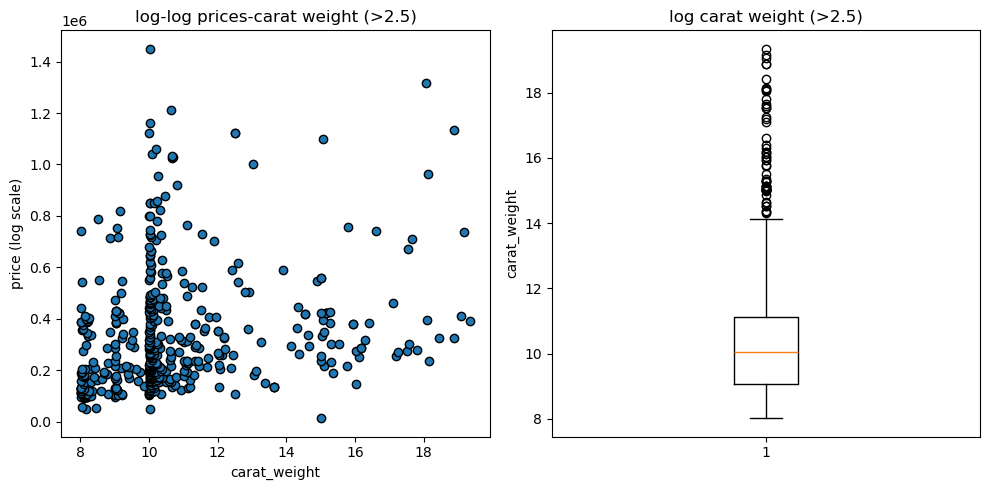

In [41]:
# Create the Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


# Histogram
ax1.scatter(x=tippy_top_cw['carat_weight'], y=tippy_top_cw['total_sales_price'],  edgecolor='black')
ax1.set_xlabel('carat_weight')
ax1.set_ylabel('price (log scale)')
ax1.set_title('log-log prices-carat weight (>2.5)')

# Box Plot (Whiskers)
ax2.boxplot(tippy_top_cw['carat_weight'])
ax2.set_ylabel('carat_weight')
ax2.set_title('log carat weight (>2.5)')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()

In [42]:
tippy_top_cw.describe()

,carat_weight,depth_percent,table_percent,meas_length,meas_width,meas_depth,total_sales_price,log_cw,log_price
count,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,4.660000e+02,466.000000,466.000000
mean,10.701481,62.760944,61.415880,14.629871,12.621888,7.900901,3.398015e+05,2.348144,12.527609
std,2.439665,6.890387,9.268488,2.407549,1.775757,1.020117,2.355987e+05,0.203903,0.649990
min,8.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.350000e+04,2.081938,9.510445
25%,9.075000,60.800000,58.000000,13.152500,11.290000,7.292500,1.749795e+05,2.205523,12.072421
50%,10.050000,62.500000,61.000000,14.030000,12.600000,7.945000,2.761680e+05,2.307573,12.528764
75%,11.120000,66.075000,66.000000,15.617500,13.920000,8.540000,4.213310e+05,2.408745,12.951174
max,19.350000,80.000000,82.000000,22.140000,17.250000,10.470000,1.449881e+06,2.962692,14.186992


In [43]:
approx10c = df[(df['carat_weight'] > 9.9) & (df['carat_weight'] <= 10.15)]

In [44]:
approx10c

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price,log_cw,log_price
215684,Pear,unknown,I2,10.04,unknown,GIA,Very Good,Very Good,unknown,N,...,unknown,unknown,unknown,Brown,unknown,Orangey,Fancy Dark,47252,2.306577,10.763250
217048,Oval,unknown,VS2,10.01,unknown,GIA,Very Good,Very Good,unknown,N,...,XTK,unknown,unknown,Yellow,unknown,unknown,Fancy Deep,104104,2.303585,11.553146
217107,Pear,I,SI2,10.01,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,unknown,unknown,Faint,unknown,unknown,unknown,unknown,106366,2.303585,11.574641
217187,Emerald,L,VS2,10.01,unknown,HRD,Excellent,Excellent,unknown,unknown,...,M,unknown,unknown,unknown,unknown,unknown,unknown,109870,2.303585,11.607053
217272,Princess,L,VVS2,10.09,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,STK,unknown,unknown,unknown,unknown,unknown,unknown,115834,2.311545,11.659913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219678,Round,G,VS1,10.14,Excellent,GIA,Excellent,Excellent,unknown,N,...,STK,unknown,unknown,unknown,unknown,unknown,unknown,851760,2.316488,13.655060
219691,Round,D,VVS2,10.10,Excellent,GIA,Excellent,Excellent,unknown,N,...,STK,unknown,unknown,unknown,unknown,unknown,unknown,1040739,2.312535,13.855442
219696,Cushion Modified,unknown,VVS1,10.00,unknown,GIA,Very Good,Excellent,unknown,unknown,...,unknown,unknown,unknown,Yellow,unknown,unknown,Fancy Vivid,1124122,2.302585,13.932513
219698,Oval,unknown,VS1,10.04,unknown,GIA,Excellent,Excellent,unknown,unknown,...,unknown,unknown,unknown,Yellow,unknown,unknown,Fancy Vivid,1161102,2.306577,13.964880


In [45]:
approx10c['total_sales_price'].min()

np.int64(47252)

In [46]:
approx10c['total_sales_price'].max()

np.int64(1449881)

### Let's take a step back

The goal here is to make a model that will give decently accurate price predictions for stones for jewelry. And probably that's something like an engagement ring as, unlike earrings, they tend to stay on. But there is a 30 fold varitation in the price of a 10 carat diamond that runs between a moderately priced car and either a rather nice car and a rather nice house in pretty well off area. But we way past what most people could afford. 

## What we have so far
So far we have the original linear charts of price/cw and a box and whiskers of carat weights [9].
Filtering it was of limited value [20, 21]
log-log of price-carat weights [26] was where we could see definite improvements. 

##### So at that point we knew we needed log-log but we need find cut off points. Either one model using IQR, or past the IQR, or two models of below an IQR cutoff and then a second one.

the 90% solution (cutoff at 2.5 cw) looked pretty good. Diamonds above were ok. Splitting it again so that were 3 models didn't help.

### Now what?
We're going to repeat this with the cutoff at the oulier point. 


In [47]:
under_outlier = df[df['carat_weight'] < upper_lim_carat_weight]
under_outlier

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price,log_cw,log_price
0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,N,...,M,unknown,unknown,unknown,unknown,unknown,unknown,200,-2.407946,5.298317
1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,N,...,STK,unknown,unknown,unknown,unknown,unknown,unknown,200,-2.407946,5.298317
2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,...,M,unknown,unknown,unknown,unknown,unknown,unknown,200,-2.407946,5.298317
3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,...,STK,unknown,unknown,unknown,unknown,unknown,unknown,200,-2.407946,5.298317
4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,N,...,STK,unknown,unknown,unknown,unknown,unknown,unknown,200,-2.407946,5.298317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219525,Radiant,unknown,VS1,0.76,unknown,GIA,Good,Very Good,unknown,N,...,XTK,unknown,unknown,Blue,unknown,unknown,Fancy Intense,399000,-0.274437,12.896717
219560,Oval,unknown,VS1,2.01,unknown,GIA,Good,Very Good,unknown,N,...,XTK,unknown,unknown,Pink,unknown,unknown,Fancy,439688,0.698135,12.993821
219684,Pear,unknown,VS2,1.51,unknown,GIA,Very Good,Very Good,unknown,N,...,unknown,unknown,Faint,Purple,Pink,unknown,Fancy Intense,966401,0.412110,13.781334
219685,Radiant,unknown,I1,0.89,unknown,GIA,Good,Good,unknown,N,...,VTK,Blue,Medium,Red,unknown,unknown,Fancy,982560,-0.116534,13.797917


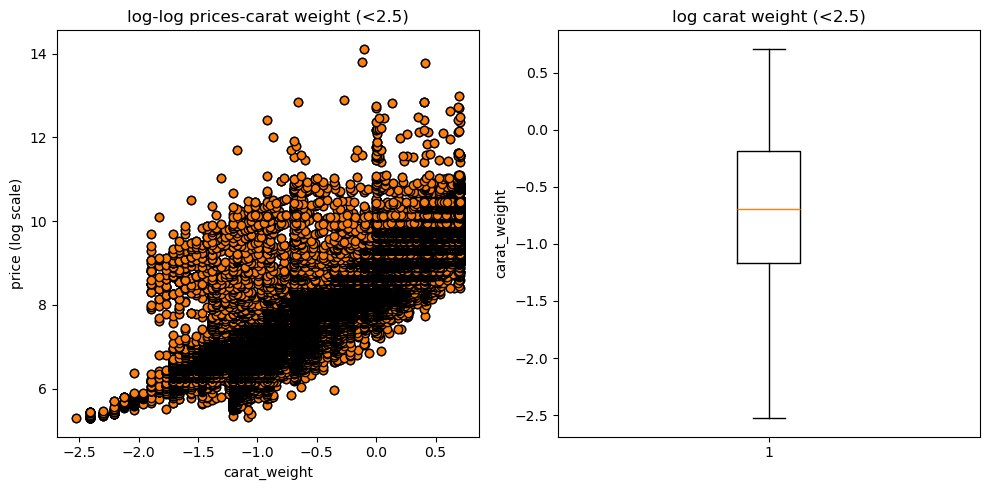

In [48]:
# Create the Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram
ax1.scatter(x=under_outlier['log_cw'], y=under_outlier['log_price'],  edgecolor='black')

#ax1.scatter(x=df['carat_weight'], y=df['log_price'],  edgecolor='black')


# Histogram
ax1.scatter(x=under_outlier['log_cw'], y=under_outlier['log_price'],  edgecolor='black')
ax1.set_xlabel('carat_weight')
ax1.set_ylabel('price (log scale)')
ax1.set_title('log-log prices-carat weight (<2.5)')

# Box Plot (Whiskers)
ax2.boxplot(under_outlier['log_cw'])
ax2.set_ylabel('carat_weight')
ax2.set_title('log carat weight (<2.5)')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()


In [49]:
outlier = df[df['carat_weight'] > upper_lim_carat_weight]

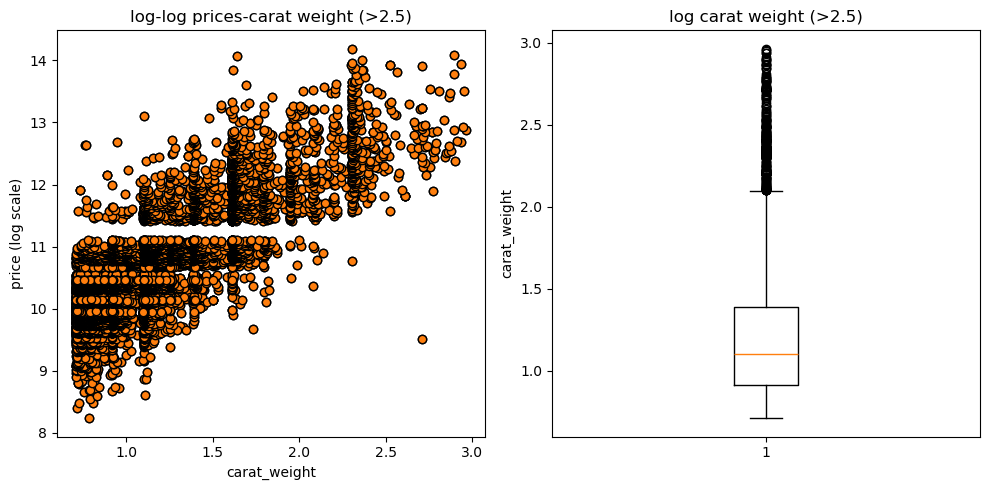

In [50]:
# Create the Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram
ax1.scatter(x=outlier['log_cw'], y=outlier['log_price'],  edgecolor='black')


# Histogram
ax1.scatter(x=outlier['log_cw'], y=outlier['log_price'],  edgecolor='black')
ax1.set_xlabel('carat_weight')
ax1.set_ylabel('price (log scale)')
ax1.set_title('log-log prices-carat weight (>2.5)')

# Box Plot (Whiskers)
ax2.boxplot(outlier['log_cw'])
ax2.set_ylabel('carat_weight')
ax2.set_title('log carat weight (>2.5)')

# Adjust Layout
plt.tight_layout()

# Display the Plots
plt.show()

OK, I'm satisfied with this. I think the only think I have to verify is that there are none above this extended range.


In [51]:
extended_Q1_carat_weight, extended_Q3_carat_weight = outlier['carat_weight'].quantile(.25), outlier['carat_weight'].quantile(.75)
extended_IQR_carat_weight = extended_Q3_carat_weight - extended_Q1_carat_weight
extended_IQR_carat_weight

np.float64(1.5099999999999998)

In [52]:
extended_upper_lim_carat_weight = extended_Q3_carat_weight + 1.5*extended_IQR_carat_weight
extended_upper_lim_carat_weight

np.float64(6.2749999999999995)

So, all put together, the model will predice diamonds up (we're going to round down here) up to 6.25 carats. 

In [53]:

# Assuming your DataFrame is named 'df'
total_diamonds = len(df)
diamonds_above_6_25 = len(df[df['carat_weight'] > 6.25])
percentage_above_6_25 = (diamonds_above_6_25 / total_diamonds) * 100
print(f"{percentage_above_6_25:.2f}% of diamonds are above 6.25 carats.")

0.31% of diamonds are above 6.25 carats.


Considering again the YOLO cutoff point, what would that look like?

In [54]:
upper_lim_carat_weight

np.float64(2.035)

In [55]:
remaining =  df[df['carat_weight'] > upper_lim_carat_weight]
len(remaining)

9447

In [56]:
# Assuming your DataFrame is named 'df'
total_diamonds = len(df)
diamonds_above_2_035 = len(remaining)
percentage_above_2_035 = (diamonds_above_2_035 / total_diamonds) * 100

print (f" {round(percentage_above_2_035, 3)} percent of {len(df)} stones are diamonds above {round(upper_lim_carat_weight, 2)} carats")

 4.3 percent of 219704 stones are diamonds above 2.04 carats


## Preparing the model 

In [57]:
### Drop rows where carat_weight is above 2.04

In [58]:
df = pd.read_parquet("../data/diamonds.parquet")

In [59]:
df = df[df.carat_weight <= 6.25]
df

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,N,...,1.79,M,M,unknown,unknown,unknown,unknown,unknown,unknown,200
1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,N,...,1.78,STK,STK,unknown,unknown,unknown,unknown,unknown,unknown,200
2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,...,1.77,TN,M,unknown,unknown,unknown,unknown,unknown,unknown,200
3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,...,1.78,M,STK,unknown,unknown,unknown,unknown,unknown,unknown,200
4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,N,...,1.82,STK,STK,unknown,unknown,unknown,unknown,unknown,unknown,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219684,Pear,unknown,VS2,1.51,unknown,GIA,Very Good,Very Good,unknown,N,...,3.58,unknown,unknown,unknown,Faint,Purple,Pink,unknown,Fancy Intense,966401
219685,Radiant,unknown,I1,0.89,unknown,GIA,Good,Good,unknown,N,...,3.16,TK,VTK,Blue,Medium,Red,unknown,unknown,Fancy,982560
219687,Radiant,unknown,VVS1,5.03,unknown,GIA,Good,Excellent,unknown,N,...,5.92,unknown,unknown,unknown,unknown,Pink,unknown,unknown,Fancy Light,1026120
219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,unknown,...,5.71,TK,XTK,unknown,unknown,Green,unknown,unknown,Fancy Light,1292500


In [60]:
main_group = df[df.carat_weight <=2.04]

In [61]:
extended_group = df[df.carat_weight > 2.04]

In [62]:
main_group['carat_weight'].describe()

count    210402.00000
mean          0.62888
std           0.42964
min           0.08000
25%           0.31000
50%           0.50000
75%           0.84000
max           2.04000
Name: carat_weight, dtype: float64

In [63]:
extended_group['carat_weight'].describe()

count    8620.000000
mean        3.140260
std         0.979399
min         2.050000
25%         2.450000
50%         3.010000
75%         3.500000
max         6.250000
Name: carat_weight, dtype: float64

OK, were going to work with just the `main_group` right after we confirm everything is split correctly.

In [64]:

def preprocess_data(df, target_col='total_sales_price', test_size=.2, val_size=0.25, random_state=1):
    """
        Preprocess the dataset by splitting it into training, validation, and test sets, 
        and separating the target variable. Default is 60/20/20 split
    
        Parameters:
        df (pd.DataFrame): The input dataframe containing the dataset.
        target_col (str): The name of the target column. Default is 'y'.
        test_size (float): The proportion of the dataset to include in the test split. Default is 0.2.
        val_size (float): The proportion of the training set to include in the validation split. Default is 0.25.
        random_state (int): The random seed used for shuffling the data. Default is 42.
    
        Returns:
        tuple: A tuple containing:
            - df_train (pd.DataFrame): The training set with the target column removed.
            - df_val (pd.DataFrame): The validation set with the target column removed.
            - df_test (pd.DataFrame): The test set with the target column removed.
            - y_train (pd.Series): The target values for the training set.
            - y_val (pd.Series): The target values for the validation set.
            - y_test (pd.Series): The target values for the test set.
        """
    
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    df_train, df_val = train_test_split(df_full_train, test_size=val_size, random_state=random_state)
    
    # Reset indices and separate target variable
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = df_train.pop(target_col)
    y_val = df_val.pop(target_col)
    y_test = df_test.pop(target_col)
    
    return df_train, df_val, df_test, y_train, y_val, y_test

# Example usage:
#df_train, df_val, df_test, y_train, y_val, y_test = preprocess_data(df, target_col='jamb_score', random_state=1)


In [65]:
df_train, df_val, df_test, y_train, y_val, y_test = preprocess_data(main_group, target_col='total_sales_price', test_size=.2, val_size=0.25, random_state=1)

In [66]:
len(df_train), len(df_val), len(df_test)

(126240, 42081, 42081)

In [67]:
ex_df_train, ex_df_val, ex_df_test, ex_y_train, ex_y_val, ex_y_test = preprocess_data(extended_group, target_col='total_sales_price', test_size=.2, val_size=0.25, random_state=1)

In [68]:
len(ex_df_train), len(ex_df_val), len(ex_df_test)

(5172, 1724, 1724)

In [69]:
## Make and run the pipeline

In [70]:
# nominal_pipeline = Pipeline(
#     steps=[("onehot", OneHotEncoder(handle_unknown="ignore")) ])
 
# clarity_pipeline = Pipeline(
#     steps=[("encoder", OrdinalEncoder()) ])

# culet_size_pipeline = Pipeline(
#     steps=[("encoder", OrdinalEncoder()) ])

# cut_quality_pipeline = Pipeline(
#     steps=[("encoder", OrdinalEncoder()) ])

# polish_pipeline = Pipeline(
#     steps=[("encoder", OrdinalEncoder()) ])

# symmetry_pipeline = Pipeline(
#     steps=[("encoder", OrdinalEncoder()) ])

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Define ordinal mappings for each ordinal column
ordinal_mappings = {
    'clarity': clarity_ord,
    'culet_size': culet_size_ord,
    'cut_quality': cut_quality_ord,
    'polish': polish_ord,
    'symmetry': symmetry_ord
}

# Ordinal encoder with predefined order
ordinal_transformers = [(col, OrdinalEncoder(categories=[categories]), [col]) for col, categories in ordinal_mappings.items()]

# Preprocessing for nominal columns using OneHotEncoder
nominal_transformer = ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_columns)

# Preprocessing for numerical columns
numerical_columns = ['carat_weight', 'depth_percent', 'table_percent', 'meas_length', 'meas_width', 'meas_depth']
numerical_transformer = ('numerical', Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values if any
    ('scaler', StandardScaler())  # Regularization via standardization
]), numerical_columns)

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        *ordinal_transformers,  # Add each ordinal transformer
        nominal_transformer,
        numerical_transformer
    ]
)


In [73]:

# Pipeline for model training
def get_model_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),

}

# Grid search parameter grids
param_grids = {
    'Linear Regression': {},
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6],
        'model__learning_rate': [0.01, 0.1, 0.2]
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20, None]
    },
}

# Train each model with cross-validation
best_models = {}

# Wrapping the outer model loop with tqdm
for model_name, model in tqdm(models.items(), desc="Models"):
    print(f"\nTraining {model_name}...")
    pipeline = get_model_pipeline(model)
    param_grid = param_grids[model_name]

    # Wrapping GridSearchCV with tqdm for verbose cross-validation progress
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1  # Setting verbose for GridSearchCV to show internal progress
    )

    # Fitting the grid search
    grid_search.fit(df_train, y_train)
    best_models[model_name] = grid_search.best_estimator_

# Evaluate models on validation data
print("\nModel Evaluation:")
for model_name, model in best_models.items():
    val_score = model.score(df_val, y_val)
    print(f"{model_name} Validation Score: {val_score}")


Models:   0%|                                                                            | 0/3 [00:00<?, ?it/s]


Training Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Models:  33%|██████████████████████▋                                             | 1/3 [00:04<00:09,  4.60s/it]


Training XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Models:  67%|█████████████████████████████████████████████▎                      | 2/3 [00:18<00:10, 10.29s/it]


Training Random Forest...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


Models: 100%|████████████████████████████████████████████████████████████████| 3/3 [2:35:02<00:00, 3100.87s/it]



Model Evaluation:
Linear Regression Validation Score: 0.6199830269332955
XGBoost Validation Score: 0.7835074067115784
Random Forest Validation Score: 0.7533094016655786


In [ ]:
Models:   0%|                                                                            | 0/3 [00:00<?, ?it/s]


Training Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Models:  33%|██████████████████████▋                                             | 1/3 [00:04<00:09,  4.60s/it]


Training XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Models:  67%|█████████████████████████████████████████████▎                      | 2/3 [00:18<00:10, 10.29s/it]


Training Random Forest...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Models: 100%|████████████████████████████████████████████████████████████████| 3/3 [2:35:02<00:00, 3100.87s/it]


Model Evaluation:
Linear Regression Validation Score: 0.6199830269332955
XGBoost Validation Score: 0.7835074067115784
Random Forest Validation Score: 0.7533094016655786


In [75]:
# Loop through each trained model and print the settings
for model_name, model in best_models.items():
    print(f"\nSettings for {model_name}:")
    print(model.get_params())



Settings for Linear Regression:
{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('clarity',
                                 OrdinalEncoder(categories=[['F', 'IF', 'VVS1',
                                                             'VVS2', 'VS1',
                                                             'VS2', 'SI1',
                                                             'SI2', 'SI3', 'I1',
                                                             'I2', 'I3']]),
                                 ['clarity']),
                                ('culet_size',
                                 OrdinalEncoder(categories=[['N', 'VS', 'S',
                                                             'M', 'SL', 'L',
                                                             'VL', 'EL',
                                                             'unknown']]),
                                 ['culet_size']),
                                ('cut_quality

In [76]:
print("Best parameters for XGBoost:", best_models['XGBoost'].get_params())

Best parameters for XGBoost: {'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('clarity',
                                 OrdinalEncoder(categories=[['F', 'IF', 'VVS1',
                                                             'VVS2', 'VS1',
                                                             'VS2', 'SI1',
                                                             'SI2', 'SI3', 'I1',
                                                             'I2', 'I3']]),
                                 ['clarity']),
                                ('culet_size',
                                 OrdinalEncoder(categories=[['N', 'VS', 'S',
                                                             'M', 'SL', 'L',
                                                             'VL', 'EL',
                                                             'unknown']]),
                                 ['culet_size']),
                                ('cut_quality',
 

In [93]:
from sklearn.metrics import root_mean_squared_error, r2_score

# Calculate RMSE and R-squared for each model on the validation set
print("Validation Scores (RMSE and R-squared):")
for model_name, model in best_models.items():
    y_pred = model.predict(df_val)

    #scoring
    rmse = root_mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    print(f"{model_name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R-squared: {r2:.2f}")


Validation Scores (RMSE and R-squared):
Linear Regression:
  RMSE: 4384.26
  R-squared: 0.62
XGBoost:
  RMSE: 3309.15
  R-squared: 0.78
Random Forest:
  RMSE: 3532.41
  R-squared: 0.75


In [ ]:
df_train, df_val, df_test, y_train, y_val, y_test = preprocess_data(main_group, target_col='total_sales_price', test_size=.2, val_size=0.25, random_state=1)